In [1]:
%matplotlib inline
import sys
sys.path.append('../')
from fns import *
import glob
import xgboost as xgb
import yadlt as ya
import keras
from keras.layers import Input, Dense, Conv3D, MaxPooling3D, UpSampling3D, merge, BatchNormalization, Dropout
from keras.models import Model
from keras import backend as K

Using TensorFlow backend.
/home/gp1514/.pyenv/versions/anaconda3-4.3.0/envs/needles/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/gp1514/.pyenv/versions/anaconda3-4.3.0/envs/needles/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/gp1514/.pyenv/versions/anaconda3-4.3.0/envs/needles/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))
/home/gp1514/.pyenv/versions/anaconda3-4.3.0/envs/needles/lib/pyt

In [2]:
import plotly
plotly.tools.set_credentials_file(username='gpernelle', api_key='4KIdNJBBApIeebdKxyN9')
import plotly.plotly as py
import plotly.graph_objs as go

In [3]:
def dice(logits, labels):
        flat_logits = logits.flatten()
        flat_labels = labels.flatten()
        intersection = np.sum(flat_logits*flat_labels)
        union = np.sum(flat_logits) + np.sum(flat_labels)
        loss = 1 - 2 * intersection / union
        return loss

### Predict

In [4]:
trainingCases = loadCases("preprocessing/training.txt")
validationCases = loadCases("preprocessing/validation.txt")
testingCases = loadCases("preprocessing/testing.txt")

In [5]:
# # for case in trainingCases:
# for case in validationCases+testingCases:
#     image_name = '/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00_split2/%s/case.nrrd'%case
#     label_name = '/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/%s/needles.nrrd'%case
#     data, options = nrrd.read(image_name)
#     label_data, options = nrrd.read(label_name)
#     data = data.astype(np.float32)
#     prediction = predict(data, "./models/unet_trained_mix_dropout-05-f3_l4_148_clahe")
#     xs,ys,zs = np.where(prediction != 0)
#     np.save('prediction/%s.npy'%case, np.array([xs,ys,zs]).T)

In [6]:
def _process_data(data, clahe_filter=True):
        data = np.clip(np.fabs(data), -np.inf, np.inf)
        # normalization
        data -= np.amin(data)
        data /= np.amax(data)
        
        # data -= np.mean(data)
        # data /= np.std(data)
        return data
    
    
def _load_file(path, dtype=np.float32):
        data = np.load(path).astype(dtype)
        return data

In [7]:
def predict_data(min_iter=np.inf, mode='training', synth=0, tile=60):
    if synth:
        synth_str = '_synth'
    else:
        synth_str = ''


    with open('preprocessing/%s_subvolumes%s.txt' % (mode, synth_str), 'r') as f:
        files = f.read().splitlines()
        
    if mode=='training':
        with open('preprocessing/%s_subvolumes_synth.txt' % (mode), 'r') as f:
            files += f.read().splitlines()
        
    
        
    # with open('preprocessing/%s_subvolumes%s.txt' % (mode,synth_str), 'r') as f:
    #     files = f.read().splitlines()
    

    data, target = [], []
    for i in trange(min(min_iter,len(files))):
        image_path = files[i]

        label_name = image_path.replace('_case', '_labelmap')
        label_name = label_name.replace('case', 'needles')

        img = _load_file(image_path, np.float32)
        #img = _process_data(img)[...,np.newaxis]
        
        prediction = predict(img, "./models/unet_trained_mix_dropout-05-f3_l4_148_clahe")
        
        xs,ys,zs = np.where(prediction != 0)
        np.save('prediction_subvolumes/x_%s.npy'%i, np.array([xs,ys,zs]).T)
                
        annotation = _load_file(label_name, np.float32)
        xs,ys,zs = np.where(annotation != 0)
        np.save('prediction_subvolumes/y_%s.npy'%i, np.array([xs,ys,zs]).T)
        
# predict_data()


## DATA for training

In [8]:
def dice_coef(y_true, y_pred, smooth=0.1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3,4])
    union = K.sum(y_true, axis=[1,2,3,4]) + K.sum(y_pred, axis=[1,2,3,4])
    return 1-K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

In [9]:
# SHAPE = (200,200,200)
# input_img = Input(shape=(SHAPE[0], SHAPE[1], SHAPE[2], 1))  # adapt this if using `channels_first` image data format

# n_filter = 16
# filter_s = (3,3,3)
# conv1 = Conv3D(n_filter, filter_s, activation='elu', padding='same')(input_img)
# conv1 = MaxPooling3D((2, 2, 2), padding='same', name='conv1')(conv1)
# conv1 = Dropout(0.5)(conv1)

# n_filter *=2
# conv2 = Conv3D(n_filter, filter_s, activation='elu', padding='same')(conv1)
# conv2 = MaxPooling3D((2, 2, 2), padding='same', name='conv2')(conv2)
# conv2 = Dropout(0.5)(conv2)


# n_filter *=2
# conv3 = Conv3D(n_filter, filter_s, activation='elu', padding='same')(conv2)
# conv3 = MaxPooling3D((2, 2, 2), padding='same')(conv3)
# conv3 = Dropout(0.5)(conv3)


# # at this point the representation is (7, 7, n_filter)

# res1 = BatchNormalization(axis=1, name='batch1')(conv3)
# res1 = Conv3D(n_filter, filter_s, activation='elu', padding='same')(res1)
# res1 = UpSampling3D((2, 2, 2), name='res1')(res1)
# res1 = Dropout(0.5)(res1)


# n_filter //=2
# res2 = BatchNormalization(axis=1, name='batch2')(res1)
# merge1 = merge((conv2, res1), mode='concat', name='merge1', concat_axis=-1)
# res2 = Conv3D(n_filter, filter_s, activation='elu', padding='same')(merge1)
# res2 = UpSampling3D((2, 2, 2), name='res2')(res2)
# res2 = Dropout(0.5)(res2)


# n_filter //=2
# res3 = BatchNormalization(axis=1, name='batch3')(res2)
# merge2 = merge((conv1, res2), mode='concat', name='merge2', concat_axis=-1)
# res3 = Conv3D(n_filter, filter_s, activation='elu', padding='same')(merge2)
# res3 = UpSampling3D((2, 2, 2))(res3)
# res3 = Dropout(0.5)(res3)


# decoded = Conv3D(1, filter_s, activation='sigmoid', padding='same')(res3)

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adadelta', loss=dice_coef)

In [10]:
# SHAPE = (200,200,200)
# input_img = Input(shape=(SHAPE[0], SHAPE[1], SHAPE[2], 1))  # adapt this if using `channels_first` image data format

# n_filter = 16
# filter_s = (5,5,5)
# conv1 = Conv3D(n_filter, filter_s, activation='elu', padding='same')(input_img)
# conv1 = MaxPooling3D((2, 2, 2), padding='same')(conv1)

# conv2 = Conv3D(n_filter, filter_s, activation='elu', padding='same')(conv1)
# conv2 = MaxPooling3D((2, 2, 2), padding='same')(conv2)

# # at this point the representation is (7, 7, n_filter)

# res1 = Conv3D(n_filter, filter_s, activation='elu', padding='same')(conv2)
# res1 = UpSampling3D((2, 2, 2))(res1)

# merge1 = merge((conv1, res1), mode='concat', name='merge1', concat_axis=1)

# res2 = Conv3D(n_filter, filter_s, activation='elu', padding='same')(res1)
# res2 = UpSampling3D((2, 2, 2))(res2)
# decoded = Conv3D(1, filter_s, activation='sigmoid', padding='same')(res2)

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss=dice_coef)

In [59]:
SHAPE = (200,200,200)
input_img = Input(shape=(SHAPE[0], SHAPE[1], SHAPE[2], 2))  # adapt this if using `channels_first` image data format

n_filter = 16
filter_s = (3,3,3)
x = Conv3D(n_filter, filter_s, activation='elu', padding='same')(input_img)
x = MaxPooling3D((2, 2, 2), padding='same')(x)
x = Conv3D(n_filter, filter_s, activation='elu', padding='same')(x)
encoded = MaxPooling3D((2, 2, 2), padding='same')(x)

# at this point the representation is (7, 7, n_filter)

x = Conv3D(n_filter, filter_s, activation='elu', padding='same')(encoded)
x = UpSampling3D((2, 2, 2))(x)
x = Conv3D(n_filter, filter_s, activation='elu', padding='same')(x)
x = UpSampling3D((2, 2, 2))(x)
decoded = Conv3D(1, filter_s, activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss=dice_coef)

In [60]:
# SHAPE = (208,208,208)
# input_img = Input(shape=(SHAPE[0], SHAPE[1], SHAPE[2], 2))  # adapt this if using `channels_first` image data format

# n_filter = 16
# filter_s = (3,3,9)
# pool_s = (4,4,4)
# x = Conv3D(n_filter, filter_s, activation='elu', padding='same')(input_img)
# x = MaxPooling3D(pool_s, padding='same')(x)
# x = Conv3D(n_filter, filter_s, activation='relu', padding='same')(x)
# encoded = MaxPooling3D(pool_s, padding='same')(x)

# # at this point the representation is (7, 7, n_filter)

# x = Conv3D(n_filter, filter_s, activation='relu', padding='same')(encoded)
# x = UpSampling3D(pool_s)(x)
# x = Conv3D(n_filter, filter_s, activation='elu', padding='same')(x)
# x = UpSampling3D(pool_s)(x)
# decoded = Conv3D(1, filter_s, activation='sigmoid', padding='same')(x)

# autoencoder = Model(input_img, decoded)
# autoencoder.compile(optimizer='adam', loss=dice_coef)

In [13]:
DTYPE = 'int8'

In [14]:
# def prepare_data_train(cases, start=0, end=100):
#     X_ = []
#     Y_ = []
#     for case in range(start,end):
#         X = np.load('prediction_subvolumes/x_%s.npy'%case).astype('uint8')
#         Y = np.load('prediction_subvolumes/y_%s.npy'%case).astype('uint8')
        
#         x = np.zeros(SHAPE).astype(DTYPE)
#         y = np.zeros(SHAPE).astype(DTYPE)
#         try:
#             x[[X[:,0], X[:,1], X[:,2]]] = 1
#             y[[Y[:,0], Y[:,1], Y[:,2]]] = 1
#             X_.append(x[:SHAPE[0], :SHAPE[1], :SHAPE[2]])
#             Y_.append(y[:SHAPE[0], :SHAPE[1], :SHAPE[2]])
#         except:
#             pass
#     X_ = np.array(X_)
#     Y_ = np.array(Y_)
#     x_train = np.reshape(X_, (X_.shape[0], SHAPE[0], SHAPE[1], SHAPE[2], 1))
#     y_train = np.reshape(Y_, (Y_.shape[0], SHAPE[0], SHAPE[1], SHAPE[2], 1))
#     return x_train, y_train

# N=100
# x_train, y_train  = prepare_data_train(trainingCases, start=0, end=N)

In [62]:
def prepare_data_train(cases, start=0, end=100, mode='training'):
    X_ = []
    Y_ = []
    
    with open('preprocessing/%s_subvolumes.txt' % (mode), 'r') as f:
        files = f.read().splitlines()
        
    with open('preprocessing/%s_subvolumes_synth.txt' % (mode), 'r') as f:
            files += f.read().splitlines()
        
    
        
    # with open('preprocessing/%s_subvolumes%s.txt' % (mode,synth_str), 'r') as f:
    #     files = f.read().splitlines()
    
    
    
    for case in range(start,end):
        image_path = files[case]
        img = _load_file(image_path, np.float32)
        to_pad = SHAPE[0] - img.shape[0]
        img = np.pad(img, [(0, to_pad), (0, to_pad), (0, to_pad)], mode='constant', constant_values=[0])
        
        X = np.load('prediction_subvolumes/x_%s.npy'%case).astype('uint8')
        Y = np.load('prediction_subvolumes/y_%s.npy'%case).astype('uint8')
        
        x = np.zeros(SHAPE).astype(DTYPE)
        y = np.zeros(SHAPE).astype(DTYPE)
        try:
            x[[X[:,0], X[:,1], X[:,2]]] = 1
            y[[Y[:,0], Y[:,1], Y[:,2]]] = 1
            
            x = x[:SHAPE[0], :SHAPE[1], :SHAPE[2]]
            
            img = np.array([x,img]).T
            
            X_.append(img)
            Y_.append(y[:SHAPE[0], :SHAPE[1], :SHAPE[2]])
        except:
            pass
    X_ = np.array(X_)
    Y_ = np.array(Y_)
    x_train = np.reshape(X_, (X_.shape[0], SHAPE[0], SHAPE[1], SHAPE[2], 2))
    y_train = np.reshape(Y_, (Y_.shape[0], SHAPE[0], SHAPE[1], SHAPE[2], 1))
    return x_train, y_train

N=10
x_train, y_train  = prepare_data_train(trainingCases, start=0, end=N)

In [63]:
def prepare_data(cases,  mode='validation'):
    X_ = []
    Y_ = []
            
    for case in cases:
        
        X = np.load('prediction/%s.npy'%case)
        
        img_path = '/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00_split2/%s/case.nrrd'%case
        img, options = nrrd.read(img_path)
        img = img.astype(np.float32)[:SHAPE[0], :SHAPE[1], :SHAPE[2]]
        to_pad = [SHAPE[i] - img.shape[i] for i in range(3)]
        img = np.pad(img, [(0, to_pad[0]), (0, to_pad[1]), (0, to_pad[2])], mode='constant', constant_values=[0])
        
        
        label_name = '/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/%s/needles.nrrd'%case
        label_data, options = nrrd.read(label_name)
        data = label_data.astype(np.float32)
        tx,ty,tz = np.where(label_data == 1)
        x = np.zeros((400,400,400)).astype(DTYPE)
        y = np.zeros((400,400,400)).astype(DTYPE)
        try:
            x[[X[:,0], X[:,1], X[:,2]]] = 1
            x = x[:SHAPE[0], :SHAPE[1], :SHAPE[2]]
            img = np.array([x,img]).T
            y[[tx,ty,tz]] = 1
            X_.append(img)
            Y_.append(y[:SHAPE[0], :SHAPE[1], :SHAPE[2]])
        except:
            pass


    X_ = np.array(X_)
    Y_ = np.array(Y_)
    x_train = np.reshape(X_, (X_.shape[0], SHAPE[0], SHAPE[1], SHAPE[2], 2))
    y_train = np.reshape(Y_, (Y_.shape[0], SHAPE[0], SHAPE[1], SHAPE[2], 1))
    return x_train, y_train

# x_train, y_train  = prepare_data(trainingCases)
# x_test, y_test = prepare_data(testingCases)
x_test, y_test = prepare_data(validationCases)

In [64]:
print(x_train.shape, x_test.shape)

(100, 200, 200, 200, 2) (11, 200, 200, 200, 2)


## Training

In [65]:
from keras.callbacks import TensorBoard


autoencoder.fit(x_train, y_train,
                epochs=100,
                batch_size=3,
                shuffle=True,
                validation_data=(x_test, y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder1')])

Train on 100 samples, validate on 11 samples
Epoch 1/100
100/100 [==============================] - 49s - loss: 0.9961 - val_loss: 0.9978
Epoch 2/100
100/100 [==============================] - 30s - loss: 0.9979 - val_loss: 1.0000
Epoch 3/100
100/100 [==============================] - 30s - loss: 1.0000 - val_loss: 1.0000
Epoch 4/100
100/100 [==============================] - 30s - loss: 1.0000 - val_loss: 1.0000
Epoch 5/100
100/100 [==============================] - 30s - loss: 1.0000 - val_loss: 1.0000
Epoch 6/100
100/100 [==============================] - 30s - loss: 1.0000 - val_loss: 1.0000
Epoch 7/100
100/100 [==============================] - 30s - loss: 1.0000 - val_loss: 1.0000
Epoch 8/100
100/100 [==============================] - 30s - loss: 1.0000 - val_loss: 1.0000
Epoch 9/100
100/100 [==============================] - 30s - loss: 1.0000 - val_loss: 1.0000
Epoch 10/100
100/100 [==============================] - 30s - loss: 1.0000 - val_loss: 1.0000
Epoch 11/100
100/100 [==

KeyboardInterrupt: 

## Save

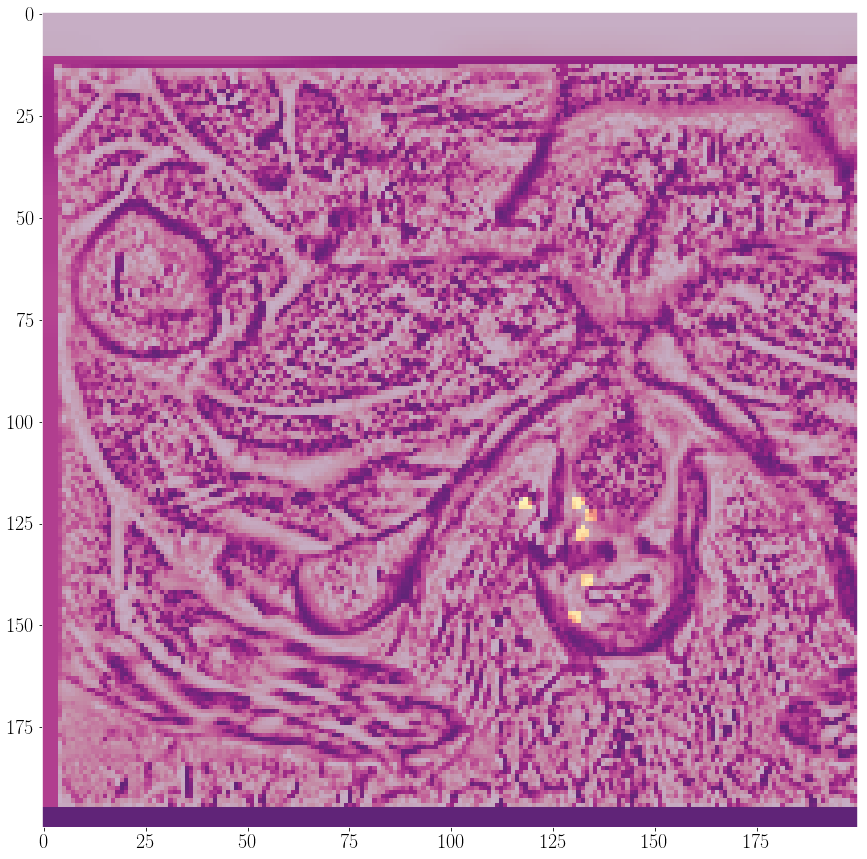

In [117]:
f(15,15)
plt.imshow(x_test[10][30,:,:,1], cmap=plt.cm.RdPu_r, alpha=0.8)
# plt.imshow(x_test[10][30,:,:,0], cmap=plt.cm.GnBu_r, alpha=0.3)

# f(15,15)
plt.imshow(y_test[10][...,30,0], alpha=0.3)

In [34]:
import h5py
from keras.models import load_model
autoencoder.save('models/unet-AE.h5')

ImportError: `save_model` requires h5py.

## Testing

In [25]:
case = '074'
label_name = '/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/%s/needles.nrrd'%case
label_data, options = nrrd.read(label_name)
tx,ty,tz = np.where(label_data == 1)
X = np.load('prediction/%s.npy'%case)

x = np.zeros((400,400,400)).astype('uint8')
y = np.zeros((400,400,400)).astype('uint8')

x[[X[:,0], X[:,1], X[:,2]]] = 1
y[[tx,ty,tz]] = 1
xtest = x[:SHAPE[0], :SHAPE[1], :SHAPE[2]]
ytest = y[:SHAPE[0], :SHAPE[1], :SHAPE[2]]

pred = autoencoder.predict(x=xtest.reshape(1,SHAPE[0], SHAPE[1], SHAPE[2],1))
print(pred.shape)
xs, ys, zs = np.where(pred[0,...,0]==1)
x, y, z = np.where(ytest==1)
print(np.sum(pred>0.1))
# pred

(1, 200, 200, 200, 1)
21808


In [26]:
dice(pred,ytest)

0.79632778326433917

In [27]:
trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=3,
        line=dict(
            color='green',
            width=2
        ),
        opacity=0.3
    )
)

trace2 = go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        color='red',
        size=3,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.3
    )
)
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~gpernelle/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


In [37]:
case=10
X = np.load('prediction_subvolumes/x_%s.npy'%case)
Y = np.load('prediction_subvolumes/y_%s.npy'%case)
x = np.zeros((200,200,200))
y = np.zeros((200,200,200))
x[[X[:,0], X[:,1], X[:,2]]] = 1
y[[Y[:,0], Y[:,1], Y[:,2]]] = 1
xx = (x[:SHAPE[0], :SHAPE[1], :SHAPE[2]])
yy = (y[:SHAPE[0], :SHAPE[1], :SHAPE[2]])

In [38]:
np.sum(Y)

1471932

In [39]:
dice(xx,yy)

0.77812593599520774

In [5]:
# image_name = '/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00_synthetic_occulted_new/numpy/training_case831.npy'
# label_name = '/home/gp1514/SSD/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00_synthetic_occulted_new/numpy/training_labelmap831.npy'
# data = np.load(image_name)
# label_data = np.load(label_name)

In [6]:
dice(prediction, label_data)

0.77363054813912235

In [7]:
islands = post_processing(prediction, min_area=int(100), max_residual=float(10))
# islands.shape

Number of regions: 817
1 1.16464669478 143
2 1.69413118611 254
3 2.75653816861 271
4 2.22627113658 157
5 1.70122839367 487
6 1.1339726399 241
7 1.1739844063 105
8 1.20633406669 190
9 1.21773331764 369
10 1.22737532168 130
11 1.13893731271 144
12 1.2177035222 145
13 1.4771532169 706
14 1.09494129293 102
15 2.95254678379 281
16 2.59886672468 701
17 1.91248214308 337
18 1.19591432983 415
19 2.2319504299 263
20 1.05359213549 102
21 1.06915015529 106
22 1.33975957664 105
23 2.08613400435 684
24 1.97584304793 867
25 1.29570554408 172
26 1.43300573738 157
27 2.13952962297 144
28 1.7041465787 134
29 1.41023546223 131
30 1.91024777151 187
31 5.71486458185 2375
32 1.0579093242 174
33 1.08515659246 162
34 1.71480695721 112
35 2.97174052751 535
36 1.35257091197 217
37 2.25076334156 382
38 1.09321486413 270
39 1.71331447339 413
40 3.02712274889 874
41 1.4697341907 138
42 1.34105154463 169
43 1.14220376308 107
44 2.01992880794 429
45 1.97009901754 121
46 2.64223737395 723
47 1.53525557151 382
48 1.4

In [33]:
import plotly.plotly as py
import plotly.graph_objs as go
x,y,z = np.where(yy == 1)
xs,ys,zs = np.where(xx != 0)

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=3,
        line=dict(
            color='green',
            width=2
        ),
        opacity=0.3
    )
)

trace2 = go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        color='red',
        size=3,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.3
    )
)
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~gpernelle/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


In [43]:
X = np.array([xs,ys,zs]).T
Y = label_data[[xs,ys,zs]]

IndexError: index 300 is out of bounds for axis 0 with size 300

In [34]:
X.shape

(73993, 3)

In [35]:
Y.shape

(73993,)

In [39]:
dtrain = xgb.DMatrix(X,label=Y)
Xtest = xgb.DMatrix(X)

In [37]:
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic' }
param['eval_metric'] = 'auc'
param['gpu_id'] = 0
param['max_bin'] = 16
param['tree_method'] = 'gpu_hist'


In [38]:
num_round = 10
bst = xgb.train( param, dtrain, num_round )

In [42]:
pred = bst.predict(Xtest)

NameError: name 'Xtest' is not defined

In [52]:
X[pred>0.5].T.shape

(3, 15094)

In [49]:
np.sum(pred>0.5)

15094

In [53]:
x,y,z = np.where(label_data == 1)
xs,ys,zs = X[pred>0.5].T

trace1 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=3,
        line=dict(
            color='green',
            width=2
        ),
        opacity=0.3
    )
)

trace2 = go.Scatter3d(
    x=xs,
    y=ys,
    z=zs,
    mode='markers',
    marker=dict(
        color='red',
        size=3,
        symbol='circle',
        line=dict(
            color='rgb(204, 204, 204)',
            width=1
        ),
        opacity=0.3
    )
)
data = [trace1, trace2]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

High five! You successfuly sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~gpernelle/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


In [ ]:
# %matplotlib notebook
# xs,ys,zs = np.where(prediction == 1)

# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.scatter(xs, ys, zs, marker='o', alpha=0.1, s=1)
# plt.show()

# # fig = plt.figure(figsize=(6,6))
# # ax = fig.add_subplot(111, projection='3d')
# xs,ys,zs = np.where(label_data == 1)
# ax.scatter(xs, ys, zs, marker='o',color='g', alpha=0.1, s=5)
# plt.show()

In [48]:
import ipyvolume.pylab as p3
p3.figure(figsize=(15,15))
ipyvolume.quickvolshow(islands, opacity=1)
ipyvolume.quickvolshow(label_data, opacity=1)

/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.4.0/envs/needles/lib/python3.6/site-packages/ipyvolume/serialize.py:29: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)
/mnt/DATA/gp1514/.pyenv/versions/anaconda3-4.4.0/envs/needles/lib/python3.6/site-packages/ipyvolume/serialize.py:29: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [35]:
x,y,z = np.where(label_data == 1)
ipyvolume.quickscatter(x,y,z, size=0.5, marker="sphere", opacity=0.2)

x,y,z = np.where(islands == 1)
ipyvolume.quickscatter(x,y,z, size=0.5, marker="sphere", opacity=0.2, color='blue')

In [ ]:
np.random.seed(1)
islands = measure.label(prediction)
K = np.max(islands)
cp =sns.color_palette("Set2", K)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
for j in range(1,K):
    xs,ys,zs = np.where(islands == j)
    ax.scatter(xs, ys, zs, marker='o',color=cp[j], alpha=0.9, s=2)
plt.show()

In [ ]:
np.random.seed(1)
islands = measure.label(label_data[i,...,0][44:-44,44:-44,44:-44])
K = np.max(islands)
cp =sns.color_palette("Set2", K)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
for j in range(1,K):
    xs,ys,zs = np.where(islands == j)
    ax.scatter(xs, ys, zs, marker='o',color=cp[j], alpha=0.9, s=2)
plt.show()

In [ ]:
image_name = '/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/075/case.nrrd'
label_name = '/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/075/needles.nrrd'

In [ ]:
# print(img.shape)
# print(data.shape)

In [ ]:
# data.shape

In [ ]:
tiles = (148,148,148)
tile = 148

In [ ]:
data, options = nrrd.read(image_name)
data = data.astype(np.float32)
print(data.shape)
d = data.resize(max(data.shape[0],tile),
               max(data.shape[1],tile),
               max(data.shape[2],tile))
print(data.shape)
print(options)

## Inference pipeline

In [ ]:
arr_data = cutVolume(data)
arr_pred = predict_full_volume(net, arr_data, model_path="./unet_trained/model 99.cpkt")
full_pred = recombine(arr_pred, data)

In [ ]:
def post_processing(full_pred, min_area=150, max_residual=10):
    ''' Clustering + removing small clusters + keeping only line-looking clusters'''
    islands_ = measure.label(full_pred)
    regions = measure.regionprops(islands_)
    islands = np.zeros_like(full_pred, dtype=np.uint8)
    K = len(regions)
    print('Number of regions: %d' % K)
    i=0
    for k in range(K):
        region = regions[k]
        coords = region.coords
        if region.area > min_area:
            lm = measure.LineModelND()
            lm.estimate(coords)
            res = lm.residuals(coords)
            mean_res = np.mean(res)
            if mean_res < max_residual:
                i+=1
                print(k, i, mean_res, np.std(res), region.area)
                for x,y,z in coords:
                    islands[x,y,z] = i


In [ ]:
islands = post_processing(full_pred)

In [ ]:
islands_ = measure.label(full_pred)
regions = measure.regionprops(islands_)
region = regions[691]
lm = measure.LineModelND()
lm.estimate(region.coords)
res = lm.residuals(region.coords)
res
K = np.max(islands)
cp = sns.color_palette("Set2", K)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')

xs,ys,zs = region.coords.T
ax.scatter(xs, ys, zs, marker='o',color=cp[j], alpha=0.9, s=2)
plt.show()

In [ ]:
print(np.unique(islands, return_counts=True))

In [ ]:
# islands = measure.label(full_pred)
K = np.max(islands)
cp = sns.color_palette("Set2", K)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
for j in range(1,K):
    xs,ys,zs = np.where(islands == j)
    ax.scatter(xs, ys, zs, marker='o',color=cp[j], alpha=0.9, s=2)
plt.show()

In [ ]:
nrrd.write('test75.nrrd', islands, options=options)

In [ ]:
islands.shape
print(np.unique(islands, return_counts=True))

In [ ]:
image_name = '/mnt/DATA/gp1514/Dropbox/2016-paolo/preprocessed_data/LabelMapsNEW2_1.00-1.00-1.00/074/needles.nrrd'
data, options = nrrd.read(image_name)
data = data.astype(np.int8)

In [ ]:
arr_labels = cutVolume(data)

In [ ]:
# '''
# EXPORT
# '''

# with tf.Graph().as_default():
#         # Inject placeholder into the graph
#         serialized_tf_example = tf.placeholder(tf.string, name='input_image')
#         feature_configs = {'data': tf.FixedLenFeature(shape=[1,148,148,148,1], dtype=tf.float32),}
#         tf_example = tf.parse_example(serialized_tf_example, feature_configs)
#         x_test = tf_example['data']
#         # now the image shape is (1,148,148,148,1)

#         # Create UNET model
#         net = Unet(channels=1, n_class=1, layers=4, pool_size=2, features_root=16, summaries=True)
#         # Create saver to restore from checkpoints
#         saver = tf.train.Saver()

#         with tf.Session() as sess:
            
#             # Restore the model from last checkpoints
#             saver.restore(sess, "./unet_trained/model 99.cpkt")
            
            
#             y_dummy = np.empty((1,148,148,148,1))

#             # (re-)create export directory
#             export_path = './export/'
#             if os.path.exists(export_path):
#                 shutil.rmtree(export_path)

#             # create model builder
#             builder = tf.saved_model.builder.SavedModelBuilder(export_path)

#             # create tensors info
#             predict_tensor_inputs_info = tf.saved_model.utils.build_tensor_info(x_test)
#             predict_tensor_scores_info = tf.saved_model.utils.build_tensor_info(net.predicter_label)

#             # build prediction signature
#             prediction_signature = (
#                 tf.saved_model.signature_def_utils.build_signature_def(
#                     inputs={'images': predict_tensor_inputs_info},
#                     outputs={'scores': predict_tensor_scores_info},
#                     method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME
#                 )
#             )

#             # save the model
#             legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
#             builder.add_meta_graph_and_variables(
#                 sess, [tf.saved_model.tag_constants.SERVING],
#                 signature_def_map={
#                     'predict_images': prediction_signature
#                 },
#                 legacy_init_op=legacy_init_op)

#             builder.save()

# print("Successfully exported UNET model")

In [133]:
import sounddevice as sd

sd.default.samplerate = fs = 44100

time = 10.0
frequency = 440
A = 10000

# Generate time of samples between 0 and two seconds
samples = np.arange(44100 * time) / 44100.0
# Recall that a sinusoidal wave of frequency f has formula w(t) = A*sin(2*pi*f*t)
wave = A * np.sin(2 * np.pi * frequency * samples)
wave = A * np.random.uniform(-1, 1, int(fs*time))
# Convert it to wav format (16 bits)
wav_wave = np.array(wave, dtype=np.int16)

sd.play(wav_wave, blocking=True)

In [189]:
def CWN(time):
    fs = 1000
    sd.default.samplerate = fs

    frequency = 440
    A = 10000

    # Generate time of samples between 0 and two seconds
    samples = np.arange(fs * time) / fs
    # Recall that a sinusoidal wave of frequency f has formula w(t) = A*sin(2*pi*f*t)
    # wave = A * np.sin(2 * np.pi * frequency * samples)
    wave = A * np.random.uniform(-1, 1, int(fs*time))
    # Convert it to wav format (16 bits)
    wav_wave = np.array(wave, dtype=np.int16)
    sd.play(wav_wave, blocking=True)
    return wave

def OWN(time, freq=12):
    fs = 1000
    sd.default.samplerate = fs
    
    # Generate time of samples between 0 and two seconds
    samples = np.arange(fs * time) / fs
    
    A = 8000 * 0.5 *(1+np.sin(2*np.pi*freq*samples)) + 2000

    
    # Recall that a sinusoidal wave of frequency f has formula w(t) = A*sin(2*pi*f*t)
    # wave = A * np.sin(2 * np.pi * frequency * samples)
    wave = A * np.random.uniform(-1, 1, int(fs*time))
    # Convert it to wav format (16 bits)
    wav_wave = np.array(wave, dtype=np.int16)
    sd.play(wav_wave, blocking=True)
    return wave

def movingaverage(values, window):
    weigths = np.repeat(1.0, window) / window
    smas = np.convolve(values, weigths, 'valid')
    return smas  # as a numpy array


def genInput(freq=12, rep=5):
    return np.concatenate([ np.concatenate([OWN(2, freq), CWN(8)]) for i in range(rep)])

In [168]:
w = OWN(15, freq=15)

(0, 1000)

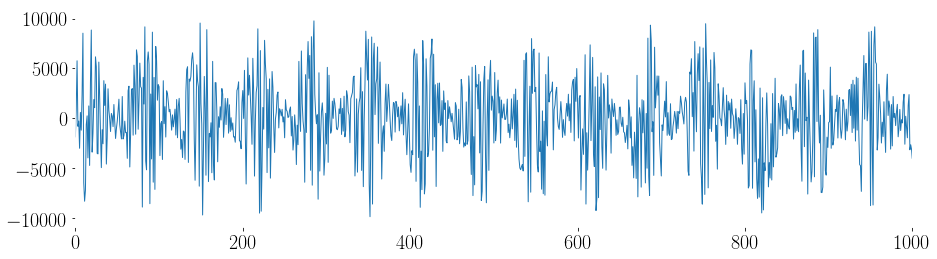

In [166]:
f(15,4)
plt.plot(w)
plt.xlim([0,1000])

In [190]:
w = genInput()
len(w)
f(15,4)
plt.plot(w)
plt.xlim([0,10000])

KeyboardInterrupt: 